In [54]:
___Author___='LumberJack Jyss'

In [55]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [56]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [57]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [58]:
df_1D = pd.read_csv('20190603 data_1D prepared.csv')
df_1D = df_1D.iloc[:,1:]
#df_1D = df_1D.drop(['Vix','P/C Ratio','Varop_vix','Varhl_vix','Spread'],axis=1)
df_1D = df_1D.dropna()
df_1D.reset_index(inplace=True,drop=True)

plt.figure(figsize=(26,20))
sns.heatmap(df_1D.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [59]:
delta = round(df_1D.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_1D.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_1D.iloc[bloc2,0],')')
print('First period :',df_1D.iloc[0,0])
print('Last period :',df_1D.iloc[df_1D.shape[0]-1,0])


# of periods :  1207
On 80% - 20% slash : 
Bloc 1 :  966  periods ( 20180618 )
Bloc 2 : 241  periods ( 20150731 )
First period : 20140815
Last period : 20190603


In [60]:
X = df_1D.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_1D.iloc[:,-3].values
y_down = df_1D.iloc[:,-2].values


In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))

In [62]:
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

Xtrain_up =  X[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','delta40_45', 'delta45_50']]
Xtrain_down = X[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]
Xtest_up =   X[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','delta40_45', 'delta45_50']]
Xtest_down = X[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]

In [63]:
Xtrain_up.shape,Xtrain_down.shape,ytrain_up.shape,ytrain_down.shape

((966, 17), (966, 17), (966,), (966,))

In [64]:
from collections import Counter
#from imblearn.combine import SMOTETomek
print('Original dataset shape_up %s' % Counter(ytrain_up))
print('Original dataset shape_down %s' % Counter(ytrain_down))

Original dataset shape_up Counter({0: 740, 1: 226})
Original dataset shape_down Counter({0: 740, 1: 226})


y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [65]:
#smt = SMOTETomek(random_state=42) #sm = SMOTE(random_state=42) #cnn = CondensedNearestNeighbour(sampling_strategy='majority',random_state=42)
#enn = EditedNearestNeighbours() #from imblearn.under_sampling import AllKNN # from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# from imblearn.under_sampling import InstanceHardnessThreshold # from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import NeighbourhoodCleaningRule # from imblearn.under_sampling import OneSidedSelection
# from imblearn.under_sampling import RandomUnderSampler

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='not majority',random_state=101) 
Xtrain_up, ytrain_up = tl.fit_resample(Xtrain_up, ytrain_up)

Xtrain_down, ytrain_down = tl.fit_resample(Xtrain_down, ytrain_down)


In [66]:
print('Resampled dataset shape %s' % Counter(ytrain_up))
print('Resampled dataset shape %s' % Counter(ytrain_down))

Resampled dataset shape Counter({0: 740, 1: 113})
Resampled dataset shape Counter({0: 740, 1: 111})


Xtrain.shape,ytrain_up.shape,Xtrain_down.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape,df_1D.iloc[:,1:-3].shape

In [67]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [68]:
ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

Xtrain_up = Xtrain_up.reshape(Xtrain_up.shape[0],Xtrain_up.shape[1])
Xtrain_down = Xtrain_down.reshape(Xtrain_down.shape[0],Xtrain_down.shape[1])

model_up = Sequential()
# Add an input layer 
model_up.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_up.add(Dense(50, activation='relu'))
# Add an output layer 
model_up.add(Dense(1, activation='sigmoid'))

model_down = Sequential()
# Add an input layer 
model_down.add(Dense(23, activation='relu'))
# Add one hidden layer 
model_down.add(Dense(50, activation='relu'))
# Add an output layer 
model_down.add(Dense(1, activation='sigmoid'))

In [69]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain_up, ytrain_up,epochs=50, batch_size=32, verbose=0)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain_down, ytrain_down,epochs=50, batch_size=32, verbose=0)

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [70]:
train_acc_up = model_up.evaluate(Xtrain_up, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain_down, ytrain_down,verbose=1)
train_acc_up,train_acc_down

851/851 [==============================] - 0s 160us/step


([0.2814313040528739, 0.8698710436558248, 0.08763618575101162],
 [0.28280385960983473, 0.8824911869790943, 0.0854575290277898])

In [71]:
yhat_up = model_up.predict_classes(Xtest_up)
yhat_down = model_down.predict_classes(Xtest_down)

In [72]:
score_up = model_up.evaluate(Xtest_up, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest_down, ytest_down,verbose=1)
score_up,score_down

241/241 [==============================] - 0s 28us/step


([0.5463479689295361, 0.7344398345195406, 0.18321847043838738],
 [0.5497046103121334, 0.7261410800747852, 0.18433768682460072])

In [73]:
confusion_matrix(ytest_up, yhat_up),

(array([[177,   3],
        [ 61,   0]]),)

In [74]:
confusion_matrix(ytest_down, yhat_down)

array([[173,   7],
       [ 59,   2]])

In [75]:
predict_up = model_up.predict(Xtest_up)
predict_down = model_down.predict(Xtest_down)

In [76]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [77]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 73.44%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 49.17% 
              precision    recall  f1-score   support

           0       0.74      0.98      0.85       180
           1       0.00      0.00      0.00        61

   micro avg       0.73      0.73      0.73       241
   macro avg       0.37      0.49      0.42       241
weighted avg       0.56      0.73      0.63       241

[[177   3]
 [ 61   0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [78]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 72.61%
Precision: 22.22%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 3.28%   => Positifs trouvés par Golem sur tous les positifs existants
ROC: 49.69% 
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       180
           1       0.22      0.03      0.06        61

   micro avg       0.73      0.73      0.73       241
   macro avg       0.48      0.50      0.45       241
weighted avg       0.61      0.73      0.64       241

[[173   7]
 [ 59   2]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [79]:
len(df_1D)-(len(df_1D)-241)

241

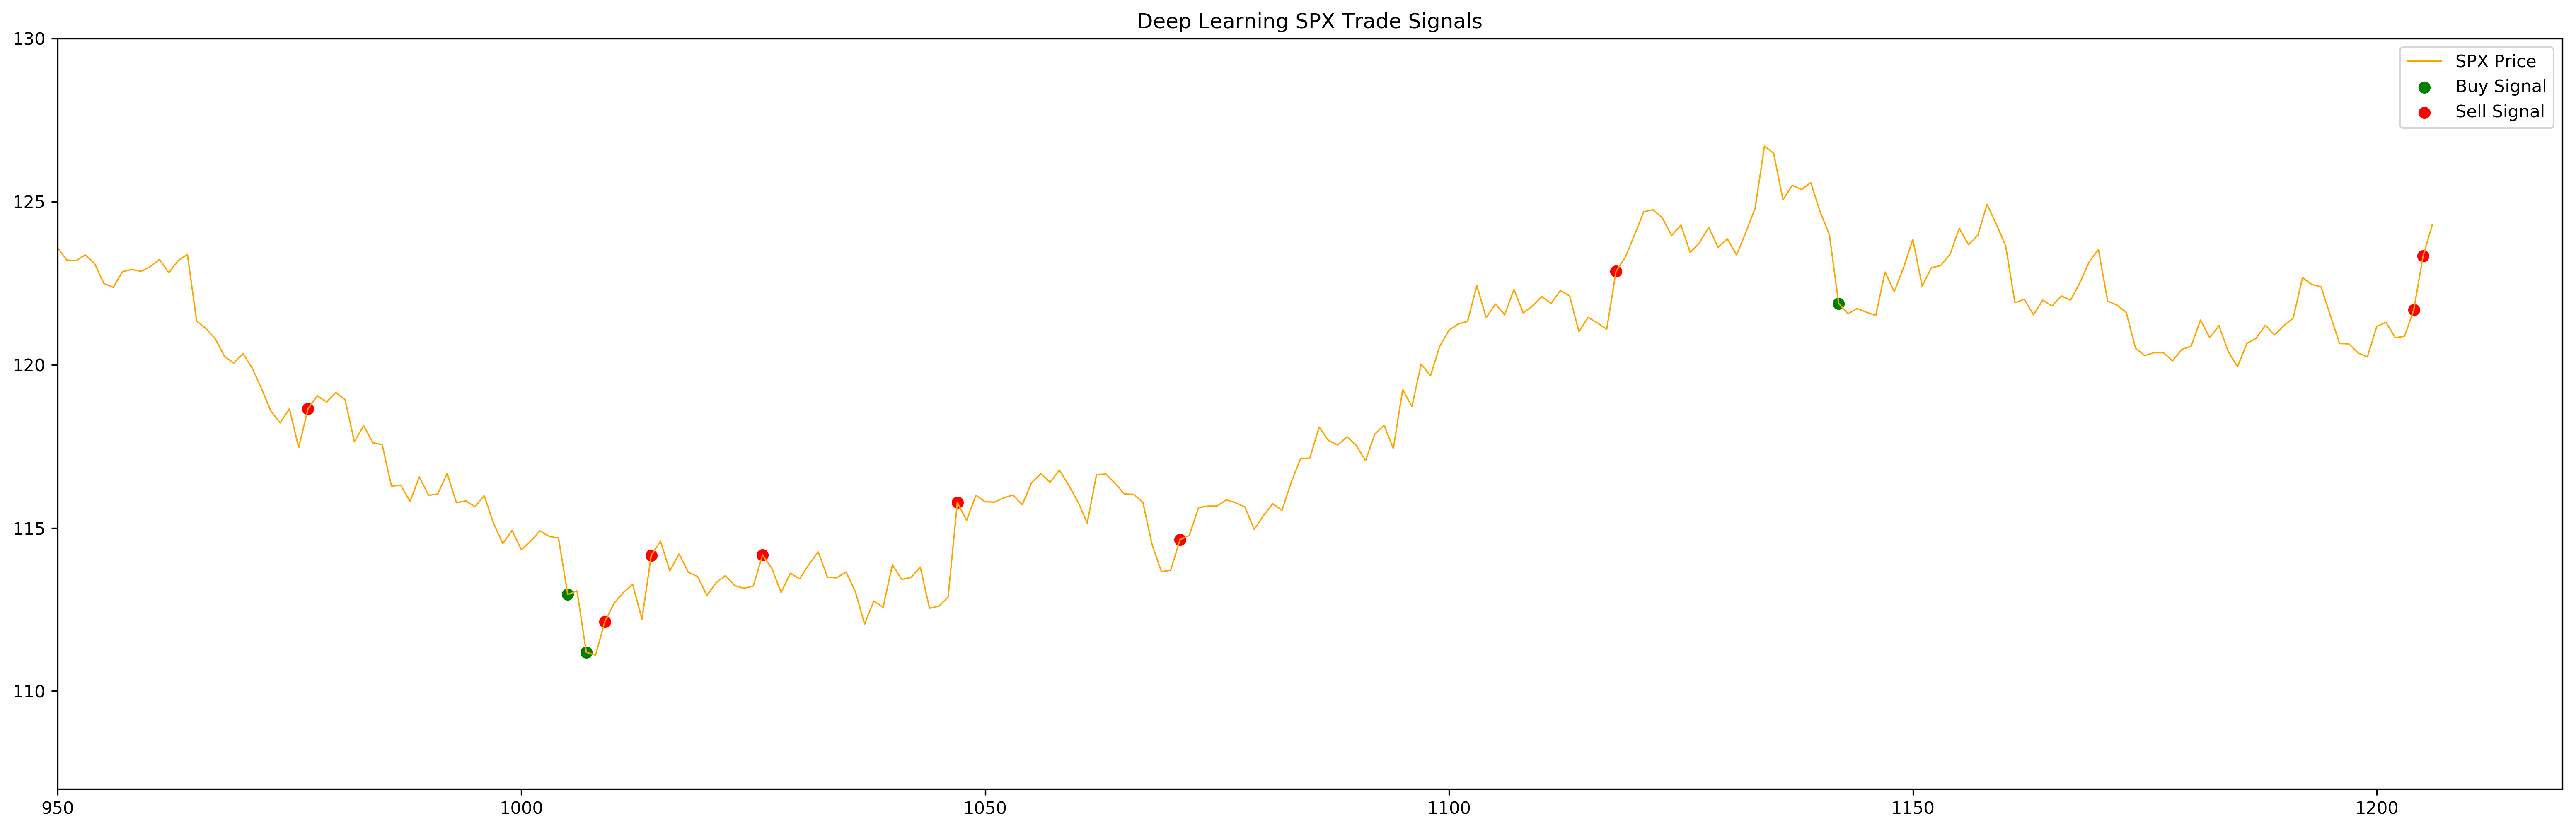

In [86]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_1D['target_value'],color='orange',lw=0.8,label='SPX Price')
plt.xlim(950,1220)
plt.ylim(107,130)
plt.scatter(x=0,y=0,c='g',marker='o',label='Buy Signal')
plt.scatter(x=0,y=0,c='r',marker='o',label='Sell Signal')
plt.title('Deep Learning SPX Trade Signals')
a = -1
for i in range(len(df_1D)-241,len(df_1D)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_1D.index[i],y=df_1D.iloc[i,-1],c='r',marker='o')
plt.legend()

In [81]:
sum(yhat_up),sum(yhat_down),i

(array([3], dtype=int32), array([9], dtype=int32), 1206)

In [82]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)